# Creation of neural net

The test and train datasets are of 4 variables and we have to create an autoencoder to compress and encode the function into 3 variabe values. These 3 variable values are then later used to decode into 4 variables data. Some of the code has been taken from Eric wulff's code. The neural network architecture has been slightly changed including the activation functions. I have used sigmoid and Linear activation functions to calculate the r2_score and MAE.

Importing all the modules 

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

This is used for switching between the cpu and gpu and atlast signifies the device being used.

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [3]:
import sys

The training and testing data is read by using pickle.

In [4]:
train = pd.read_pickle('all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('all_jets_test_4D_100_percent.pkl')
train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


## Normalization of the data and conversion to tensor form

In [5]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x
train_x = train_x
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values,dtype=torch.float), torch.tensor(train_y.values,dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values,dtype=torch.float), torch.tensor(test_y.values,dtype=torch.float))

## Differentiation into train and valid sets

In [12]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True),
        DataLoader(valid_ds, batch_size=bs * 2, pin_memory=True),
    )
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

## Creation of a function named fit taking in the arguments as number of epochs, model used etc. 

In [13]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl,device):
    since = time.time()
    epochs_train_loss = []
    epochs_val_loss = []
    for epoch in range(epochs):
        running_train_loss = 0.
        epoch_start = time.perf_counter()
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            loss, lenxb = loss_batch(model, loss_func, xb, yb, opt)
            running_train_loss += np.multiply(loss, lenxb)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb_tmp.to(device), yb_tmp.to(device)) for xb_tmp, yb_tmp in valid_dl]
            )
        train_loss = running_train_loss / len(train_dl.dataset)
        epochs_train_loss.append(train_loss)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        epochs_val_loss.append(val_loss)
        if(epoch % 1 == 0):
            current_time = time.perf_counter()
            delta_t = current_time - epoch_start
            # print('Epoch ' + str(epoch) + ':', 'Validation loss = ' + str(val_loss) + ' Time: ' + str(datetime.timedelta(seconds=delta_t)))
            print('Epoch: {:d} Train Loss: {:.3e} Val Loss: {:.3e}, Time: {}'.format(epoch, train_loss, val_loss, str(datetime.timedelta(seconds=delta_t))))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    a=pd.DataFrame({'Epoch': np.arange(epochs), 'train_loss': np.array(epochs_train_loss), 'val_loss': np.array(epochs_val_loss), 'epoch_time': delta_t})
    return (a)

In [14]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

## Neural network architecture

In [15]:
class AE_3D(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D, self).__init__()
        self.en1 = nn.Linear(n_features, 100)
        self.en2 = nn.Linear(100, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 100)
        self.de4 = nn.Linear(100, n_features)
        self.sigmoid = nn.Sigmoid()
    def encode(self, x):
        return self.en4(self.sigmoid(self.en3(self.sigmoid(self.en2(self.sigmoid(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.sigmoid(self.de3(self.sigmoid(self.de2(self.sigmoid(self.de1(self.sigmoid(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z).float()

In [16]:
n_features = len(train.loc[0])
model = AE_3D()

# Training and validation

In [17]:
epochs_list = [50,100,100]
lrs = [2e-2,1e-3,4e-4]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    b=fit(epochs, model, loss_func, opt, train_dl, valid_dl,device)

Setting learning rate to 2.0e-02
Epoch: 0 Train Loss: 7.409e-01 Val Loss: 3.775e-01, Time: 0:00:03.020570
Epoch: 1 Train Loss: 2.839e-01 Val Loss: 2.376e-01, Time: 0:00:03.254755
Epoch: 2 Train Loss: 2.091e-01 Val Loss: 2.047e-01, Time: 0:00:03.320181
Epoch: 3 Train Loss: 1.877e-01 Val Loss: 1.696e-01, Time: 0:00:03.176237
Epoch: 4 Train Loss: 1.501e-01 Val Loss: 1.373e-01, Time: 0:00:03.451336
Epoch: 5 Train Loss: 1.314e-01 Val Loss: 1.567e-01, Time: 0:00:03.400886
Epoch: 6 Train Loss: 1.266e-01 Val Loss: 1.362e-01, Time: 0:00:03.478449
Epoch: 7 Train Loss: 1.201e-01 Val Loss: 1.204e-01, Time: 0:00:03.639685
Epoch: 8 Train Loss: 1.309e-01 Val Loss: 1.304e-01, Time: 0:00:03.556497
Epoch: 9 Train Loss: 1.241e-01 Val Loss: 1.168e-01, Time: 0:00:03.421916
Epoch: 10 Train Loss: 1.200e-01 Val Loss: 1.361e-01, Time: 0:00:03.508092
Epoch: 11 Train Loss: 1.120e-01 Val Loss: 1.025e-01, Time: 0:00:03.459831
Epoch: 12 Train Loss: 1.041e-01 Val Loss: 9.599e-02, Time: 0:00:03.547594
Epoch: 13 Train

## Loss curve plotting

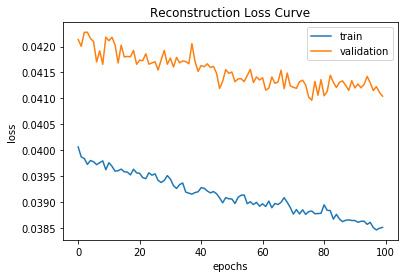

In [27]:
qw=b['Epoch']
qe=b['train_loss']
qr=b['val_loss']
plt.plot(qw,qe)
plt.plot(qw,qr)
plt.legend(['train','validation'],loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Reconstruction Loss Curve')
plt.savefig('reconstruction_loss.png',dpi=500,bbox_inches='tight')

In [28]:
model.eval()

AE_3D(
  (en1): Linear(in_features=4, out_features=100, bias=True)
  (en2): Linear(in_features=100, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=100, bias=True)
  (de4): Linear(in_features=100, out_features=4, bias=True)
  (sigmoid): Sigmoid()
)

In [29]:
print('Comparing input and output:')
for ii in np.arange(90, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([-0.5882, -0.5500, -0.0253, -0.5578])
Out: tensor([-0.4863, -0.5551, -0.0255, -0.5996], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.6324, -0.6263, -1.3302,  0.5757])
Out: tensor([-0.5055, -0.5690, -1.3458,  0.5658], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.5246, -0.5677,  0.6246, -0.3912])
Out: tensor([-0.4761, -0.5404,  0.6169, -0.3751], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.6592, -0.4873,  0.0388, -1.1115])
Out: tensor([-0.4989, -0.5496,  0.0240, -1.1212], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.6496, -0.6000,  0.2087,  0.7939])
Out: tensor([-0.4825, -0.5409,  0.2123,  0.7904], grad_fn=<AddBackward0>)
 
Inp: tensor([-1.2048, -0.2137, -0.5692,  2.4992])
Out: tensor([-0.7682, -0.3039, -0.6679,  2.7915], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.4566, -0.5710, -0.5364, -0.2376])
Out: tensor([-0.4861, -0.5607, -0.5340, -0.2458], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.6452,  0.0159,  1.4615,  1.8918])
Out: tensor([-0.4052, -0.1622,  1.5430, 

Below cells are used for unnormalizing the values.

In [30]:
aa=[]
ab=[]
for each in valid_ds.tensors[0]:
    aa.append((each*train_std)+train_mean)
    c=(model(each)).detach().numpy()
    ab.append((c*train_std)+train_mean)

In [31]:
ac=[]
ad=[]
ae=[]
af=[]
ag=[]
ah=[]
ai=[]
aj=[]
i=0
while(i<len(aa)):
    ac.append(aa[i][0])
    ad.append(ab[i][0])
    ae.append(aa[i][1])
    af.append(ab[i][1])
    ag.append(aa[i][2])
    ah.append(ab[i][2])
    ai.append(aa[i][3])
    aj.append(ab[i][3])
    i+=1

# Analysis by plots

The plots between estimated and original values are constructed for different parameters. These plots do show a correlation of 1 between the estimated and original values. Note that all the values which were normalized before passing through the encoder and the normalized values obtained are again unnormlized to their original form by using mean and standard deviation. The red lines are the regression lines obtained as best fitted slope lines using the regression points. The dashed line is y=x line.

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statistics import mean
import numpy as np
def best_fit_slope(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    return m
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
a="R2".translate(SUP)
c="0C".translate(SUP)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black'}

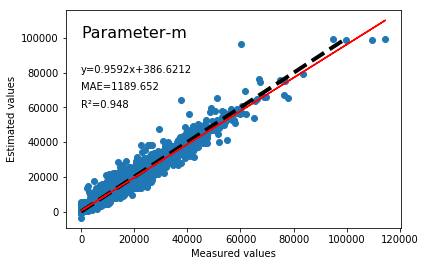

In [35]:
fig, ax = plt.subplots()
data1=ac
data2=ad
xs = np.array(data1, dtype=np.float64)
ys = np.array(data2, dtype=np.float64)
m = best_fit_slope(xs,ys)
b = mean(ys) - m*mean(xs)
import matplotlib.pyplot as plt
ax.scatter(data1, data2)
yt=int(max(data2))
ax.plot([0, yt], [0, yt], 'k--', lw=4)
y=m*xs+b
ax.plot(xs,y,color='red',label='y='+str(m)+'x'+'+'+str(b))
ax.set_xlabel('Measured values')
ax.set_ylabel('Estimated values')
ax.text(10,100000,'Parameter-m', **title_font)
ax.text(10,80000,'y='+str(round(m,4))+'x'+'+'+str(round(b,4)))
ax.text(10,60000,str(a)+'='+str(round(r2_score(data1,data2),3)))
ax.text(10,70000,'MAE='+str(round(mean_absolute_error(data1,data2),3)))
plt.savefig('RegressionPlotm.png',dpi=500,bbox_inches='tight')
plt.show()

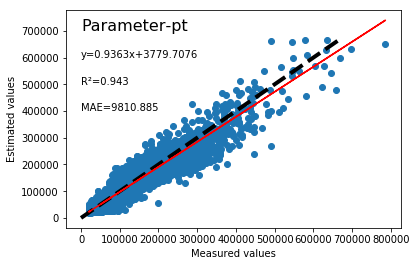

In [36]:
fig, ax = plt.subplots()
data1=ae
data2=af
xs = np.array(data1, dtype=np.float64)
ys = np.array(data2, dtype=np.float64)
m = best_fit_slope(xs,ys)
b = mean(ys) - m*mean(xs)
import matplotlib.pyplot as plt
ax.scatter(data1, data2)
yt=int(max(data2))
ax.plot([0, yt], [0, yt], 'k--', lw=4)
y=m*xs+b
ax.plot(xs,y,color='red',label='y='+str(m)+'x'+'+'+str(b))
ax.set_xlabel('Measured values')
ax.set_ylabel('Estimated values')
ax.text(10,700000,'Parameter-pt', **title_font)
ax.text(10,600000,'y='+str(round(m,4))+'x'+'+'+str(round(b,4)))
ax.text(10,500000,str(a)+'='+str(round(r2_score(data1,data2),3)))
ax.text(10,400000,'MAE='+str(round(mean_absolute_error(data1,data2),3)))
plt.savefig('RegressionPlotpt.png',dpi=500,bbox_inches='tight')
plt.show()

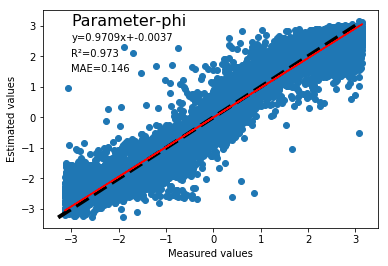

In [42]:
fig, ax = plt.subplots()
data1=ag
data2=ah
xs = np.array(data1, dtype=np.float64)
ys = np.array(data2, dtype=np.float64)
m = best_fit_slope(xs,ys)
b = mean(ys) - m*mean(xs)
import matplotlib.pyplot as plt
ax.scatter(data1, data2)
yt=int(max(data2))
yu=(min(data2))
ax.plot([yu, yt], [yu, yt], 'k--', lw=4)
y=m*xs+b
ax.plot(xs,y,color='red',label='y='+str(m)+'x'+'+'+str(b))
ax.set_xlabel('Measured values')
ax.set_ylabel('Estimated values')
ax.text(-3,3,'Parameter-phi', **title_font)
ax.text(-3,2.5,'y='+str(round(m,4))+'x'+'+'+str(round(b,4)))
ax.text(-3,2,str(a)+'='+str(round(r2_score(data1,data2),3)))
ax.text(-3,1.5,'MAE='+str(round(mean_absolute_error(data1,data2),3)))
plt.savefig('Regressionplotphi.png',dpi=500)
plt.show()

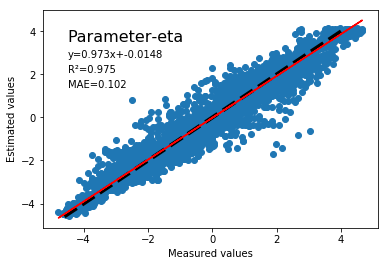

In [43]:
fig, ax = plt.subplots()
data1=ai
data2=aj
xs = np.array(data1, dtype=np.float64)
ys = np.array(data2, dtype=np.float64)
m = best_fit_slope(xs,ys)
b = mean(ys) - m*mean(xs)
import matplotlib.pyplot as plt
ax.scatter(data1, data2)
yt=int(max(data2))
yu=(min(data2))
ax.plot([yu, yt], [yu, yt], 'k--', lw=4)
y=m*xs+b
ax.plot(xs,y,color='red',label='y='+str(m)+'x'+'+'+str(b))
ax.set_xlabel('Measured values')
ax.set_ylabel('Estimated values')
ax.text(-4.5,3.5,'Parameter-eta', **title_font)
ax.text(-4.5,2.8,'y='+str(round(m,4))+'x'+'+'+str(round(b,4)))
ax.text(-4.5,2.1,str(a)+'='+str(round(r2_score(data1,data2),3)))
ax.text(-4.5,1.4,'MAE='+str(round(mean_absolute_error(data1,data2),3)))
plt.savefig('Regressionploteta.png',dpi=500,bbox_inches='tight')
plt.show()

## Plots specific to the task

Here are the plots specifically required by the task. "The plots of the difference between original and uncompressed variables for each entry of the dataset, divided by the original variable. If a(i) refers to the original value of the dataset, and b(i) refers to the value i.e. uncompressed variable and obtained by passing through the Autoencoder. Then the difference is calculated by b(i)-a(i) and relative difference calculated by (b(i)-a(i)/a(i)).

In [44]:
ma=[]
mb=[]
md=[]
me=[]
mc=[]
po=0
while(po<len(ac)):
    ma.append((ad[po]-ac[po])/ac[po])
    mc.append((af[po]-ae[po])/ae[po])
    md.append((ah[po]-ag[po])/ag[po])
    me.append((aj[po]-ai[po])/ai[po])
    mb.append(po)
    po+=1

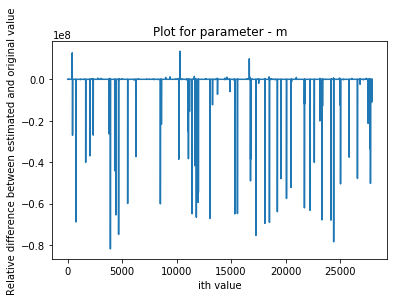

In [45]:
plt.plot(mb,ma)
plt.xlabel('ith value')
plt.ylabel('Relative difference between estimated and original value')
plt.title('Plot for parameter - m')
plt.savefig('Relativediferrenceplotm.png',dpi=500,bbox_inches='tight')

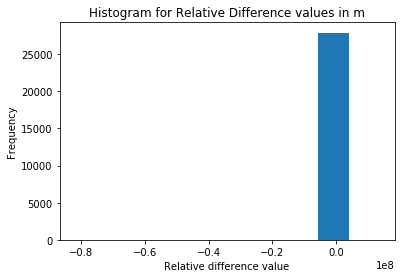

In [46]:
plt.hist(ma)
plt.ylabel('Frequency')
plt.xlabel('Relative difference value')
plt.title('Histogram for Relative Difference values in m')
plt.savefig('Relativedifferencevalueshistogramm.png',dpi=500,bbox_inches='tight')

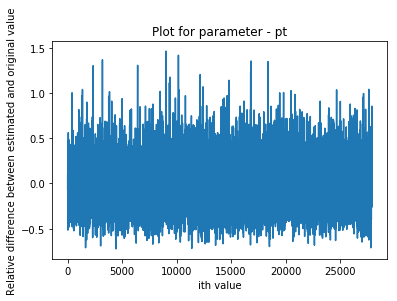

In [47]:
plt.plot(mb,mc)
plt.xlabel('ith value')
plt.ylabel('Relative difference between estimated and original value')
plt.title('Plot for parameter - pt')
plt.savefig('Relativedifferencevaluespt.png',dpi=500,bbox_inches='tight')

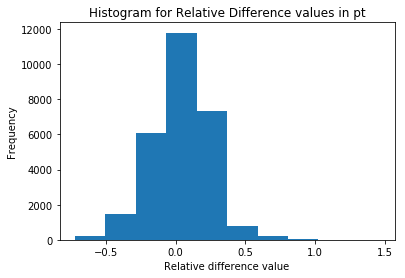

In [48]:
plt.hist(mc)
plt.ylabel('Frequency')
plt.xlabel('Relative difference value')
plt.title('Histogram for Relative Difference values in pt')
plt.savefig('Relativedifferencevaluespthist.png',dpi=500,bbox_inches='tight')

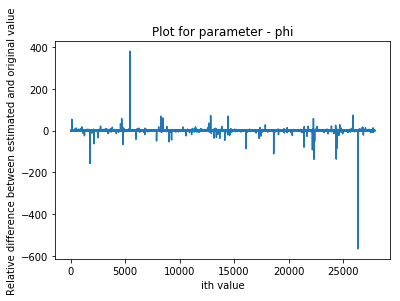

In [49]:
plt.plot(mb,md)
plt.xlabel('ith value')
plt.ylabel('Relative difference between estimated and original value')
plt.title('Plot for parameter - phi')
plt.savefig('Relativedifferencevaluesphi.png',dpi=500,bbox_inches='tight')

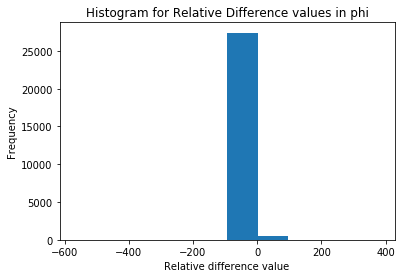

In [52]:
plt.hist(md)
plt.ylabel('Frequency')
plt.xlabel('Relative difference value')
plt.title('Histogram for Relative Difference values in phi')
plt.savefig('Relativedifferencevaluesphihist.png',dpi=500,bbox_inches='tight')

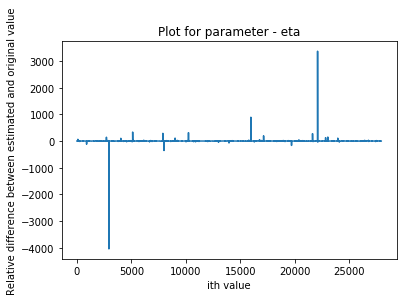

In [53]:
plt.plot(mb,me)
plt.xlabel('ith value')
plt.ylabel('Relative difference between estimated and original value')
plt.title('Plot for parameter - eta')
plt.savefig('Relativedifferencevalueseta.png',dpi=500,bbox_inches='tight')

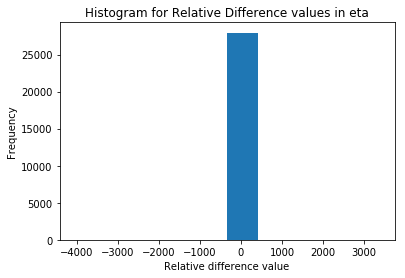

In [54]:
plt.hist(me)
plt.ylabel('Frequency')
plt.xlabel('Relative difference value')
plt.title('Histogram for Relative Difference values in eta')
plt.savefig('Relativedifferencevaluesetahist.png',dpi=500,bbox_inches='tight')